## Pocesamiento de data

In [1]:
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns
import pandas as pd
import numpy as np
import random

In [2]:
drive.mount('/content/drive/')
path = '/content/drive/MyDrive/ML_P4/train.csv'
df = pd.read_csv(path)
df.info()


Mounted at /content/drive/
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  25000 non-null  object
 1   label    25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [3]:
random_indices = random.sample(range(len(df)), 10)

for index in random_indices:
  print(df['message'][index])
  print()

This is the story of Australian commandos who are captured out of uniform after a raid. Since they are out of uniform, they are, justly, treated as spies. As such, they are tried, convicted, and sentenced to death. The Japanese court-martial, out of admiration for their heroism, authorizes that they be given a warrior's death. Of course, under the code of Bushido, this means that they are to be beheaded. A fate for which, as westerners, they are unprepared.

The small California town of Diablo is plagued with mysterious deaths after sheriff Robert Lopez unearths an ancient box.Legend has it that the box holds the sixteenth-century Mexican demon named Azar.FBI agent Gil Vega is sent to investigate the murders and joins forces with the sheriff's daughters,Dominique and Mary to fight with evil and bloodthirsty demon."The Legend of Diablo" is an absolute garbage.The film lacks scares and gore,the acting is amateurish and the direction is bad.The animation is the only one aspect of the film

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Preprocesamiento

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import tensorflow as tf

In [6]:

def preprocess(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [re.sub(r'\@\w+|\#', '', token) for token in tokens]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = ' '.join(tokens)
    return text

In [7]:
# Aplicamos
df['processed_text'] = df['message'].apply(preprocess)
df['processed_text'] = df['processed_text'].replace('', np.nan)
df = df.dropna(subset=['processed_text'])

df['label'] = df['label'].map({'neg': 0, 'pos': 1})

In [8]:
# Split
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['label'], test_size=0.2, random_state=42)

# Tokenize
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Train Word2Vec
sentences = [text.split() for text in df['processed_text']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Embedding matrix
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

## Modelo: LSTM


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score


In [10]:

batch_size = 32
if not isinstance(X_train_pad, torch.Tensor):
    X_train_tensor = torch.tensor(X_train_pad, dtype=torch.long)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
if not isinstance(X_test_pad, torch.Tensor):
    X_test_tensor = torch.tensor(X_test_pad, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
valid_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
class SentimentLSTM(nn.Module):
    def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, embed_matrix, output_dim=1): # Added dropout as a parameter
        super(SentimentLSTM, self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.no_layers = no_layers
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embed_matrix), freeze=True)

        # LSTM Layer
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=self.hidden_dim,
                            num_layers=no_layers,
                            batch_first=True)

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)

        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        out = self.dropout(lstm_out)
        out = self.fc(out)

        sig_out = self.sig(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        return sig_out, hidden

    def init_hidden(self, batch_size):
        hidden_state = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        cell_state = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        hidden = (hidden_state, cell_state)
        return hidden


In [12]:
def train(model, train_loader, criterion, optimizer, device, batch_size, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        hidden = model.init_hidden(batch_size)

        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            hidden = tuple([h.detach() for h in hidden])
            outputs, hidden = model(inputs, hidden)

            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()

            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')

In [13]:

embed_dim = 100
hidden_dim = 64
layers = 2
output_dim = 1
num_epochs = 10
learning_rate = 0.001

model = SentimentLSTM(layers, vocab_size, hidden_dim, embed_dim, embedding_matrix, output_dim).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train(model, train_loader, criterion, optimizer, device, batch_size, num_epochs)

Epoch 1/10, Loss: 0.6280770396232604
Epoch 2/10, Loss: 0.6488441428661347
Epoch 3/10, Loss: 0.5393719664096832
Epoch 4/10, Loss: 0.4570715966939926
Epoch 5/10, Loss: 0.42031548671722413
Epoch 6/10, Loss: 0.4039779952287674
Epoch 7/10, Loss: 0.3923385228872299
Epoch 8/10, Loss: 0.469938319849968
Epoch 9/10, Loss: 0.42863401284217834
Epoch 10/10, Loss: 0.38205212342739103


In [14]:

def evaluate_model(model, valid_loader, device):
    model.eval()
    y_pred = []
    y_test = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            hidden = model.init_hidden(inputs.size(0))
            outputs, hidden = model(inputs, hidden)
            y_pred.extend((outputs.squeeze() > 0.5).float().cpu().numpy())
            y_test.extend(labels.cpu().numpy())

    y_pred = np.array(y_pred)
    y_test = np.array(y_test)

    return y_test, y_pred


def matriz_confusion(y_test, y_pred, Tipo):
    matrix = confusion_matrix(y_test, y_pred)
    f2 = pd.DataFrame(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], index=["Negative", 'Positive'], columns=["Negative", 'Positive'])
    sns.heatmap(f2, annot=True, cbar=None, cmap="Greens")
    plt.title("Confusion Matrix " + Tipo)
    plt.tight_layout()
    plt.xlabel("Predicted")
    plt.ylabel("Real")
    plt.show()

def calculate_metrics(y_test, y_pred):
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")


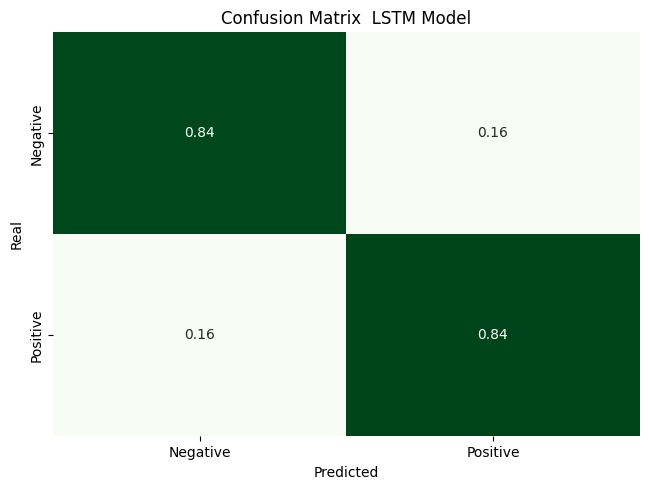

F1 Score: 0.8422083007047768
Precision: 0.8422083007047768
Recall: 0.8422083007047768
              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84      2446
         1.0       0.84      0.84      0.84      2554

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



In [15]:
y_test_eval, y_pred_eval = evaluate_model(model, valid_loader, device)

matriz_confusion(y_test_eval, y_pred_eval, " LSTM Model")

calculate_metrics(y_test_eval, y_pred_eval)

print(classification_report(y_test_eval, y_pred_eval))

## Predicción usando el modelo cargado


In [16]:

def predict_text(text, model, embedding_matrix, tokenizer, device, max_length=300):
    word_indices = tokenizer.texts_to_sequences([text])

    pad_sequence = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(word_indices[0][:max_length], dtype=torch.long)],
        batch_first=True, padding_value=0)

    embed_sequence = torch.tensor([
        embedding_matrix[word_idx] if word_idx < len(embedding_matrix) else np.zeros(100)
        for word_idx in pad_sequence[0]
    ], dtype=torch.float32)

    embed_sequence = embed_sequence.unsqueeze(0).to(device)

    batch_size = 1
    h = model.init_hidden(batch_size)
    h = tuple([e.to(device) for e in h])

    model.eval()
    with torch.no_grad():
        pad_sequence = pad_sequence.type(torch.long).to(device)
        output, h = model(pad_sequence, h)
    return output.item()

def predict_and_display(df, model, embedding_matrix, tokenizer, device):
    predicted_sentiments = []

    for idx, row in df.iterrows():
        review = row['message']

        predicted_sentiment = predict_text(review, model, embedding_matrix, tokenizer, device)
        predicted_sentiments.append(predicted_sentiment)

    df['predicted_sentiment'] = ['pos' if pred > 0.45 else 'neg' for pred in predicted_sentiments]

    print("DataFrame con predicciones:")
    print(df.head())
    print()

In [ ]:
path1 = '/content/drive/MyDrive/ML_P4/test.csv'
df_test = pd.read_csv(path1)
predict_and_display(df_test, model, embedding_matrix, tokenizer, device)

<ipython-input-16-5773fbb9a381>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  embed_sequence = torch.tensor([


In [ ]:
df_test["ids"] = range(len(df_test))

df_test.rename(columns={"predicted_sentiment": "label"}, inplace=True)

df_test.to_csv("mi_archivo.csv", columns=["ids", "label"], index=False)